# Assignment 6
### Conv Neural Nets

#### Sherwyn Braganza

In [15]:
import os, shutil, pathlib
import numpy as np

"""
    Preprocess data and seperate it into train, val and test sets.
    
"""
original_dir = pathlib.Path("data")
new_base_dir = pathlib.Path("processed_classes")

if os.path.isdir(new_base_dir):
    shutil.rmtree(new_base_dir)

def make_subset(subset_name, start_index, end_index):
    count = 0
    for category in ("circle", "digits", "triangle"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}_{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
            count+=1 
            
    return str(count) + ' samples in ' + subset_name
            
data_split = np.rint(np.array([0.5, 0.75, 1]) * 1000).astype('int32')
            
print(make_subset("train", start_index=0, end_index=data_split[0]))
print(make_subset("validation", start_index=data_split[0], end_index=data_split[1]))
print(make_subset("test", start_index=data_split[1], end_index=data_split[2]))

1500 samples in train
750 samples in validation
750 samples in test


In [16]:
# Build the conv net architecture

from tensorflow import keras
from tensorflow.keras import layers

image_shape = (100, 100)

inputs = keras.Input(shape=(image_shape[0], image_shape[1], 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# model.summary()

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=image_shape,
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=image_shape,
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=image_shape,
    batch_size=32)

Found 1500 files belonging to 3 classes.
Found 750 files belonging to 3 classes.
Found 750 files belonging to 3 classes.


In [18]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 100, 100, 3)
labels batch shape: (32,)


In [19]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="part1_convnet.keras",
        save_best_only=True,
        monitor="val_loss")
]

callbacks = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
47/47 [==============================] - 28s 577ms/step - loss: 1.3106 - accuracy: 0.4647 - val_loss: 0.6171 - val_accuracy: 0.7053
Epoch 2/10
47/47 [==============================] - 24s 507ms/step - loss: 0.6426 - accuracy: 0.7500 - val_loss: 0.3177 - val_accuracy: 0.8587
Epoch 3/10
47/47 [==============================] - 25s 524ms/step - loss: 0.3935 - accuracy: 0.8553 - val_loss: 0.1830 - val_accuracy: 0.9200
Epoch 4/10
47/47 [==============================] - 24s 501ms/step - loss: 0.8064 - accuracy: 0.8867 - val_loss: 0.1413 - val_accuracy: 0.9467
Epoch 5/10
47/47 [==============================] - 25s 526ms/step - loss: 0.3215 - accuracy: 0.9267 - val_loss: 0.1078 - val_accuracy: 0.9533
Epoch 6/10
47/47 [==============================] - 25s 535ms/step - loss: 0.3573 - accuracy: 0.9213 - val_loss: 0.0840 - val_accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 22s 468ms/step - loss: 0.2366 - accuracy: 0.9393 - val_loss: 0.1066 - val_accuracy: 0.9627

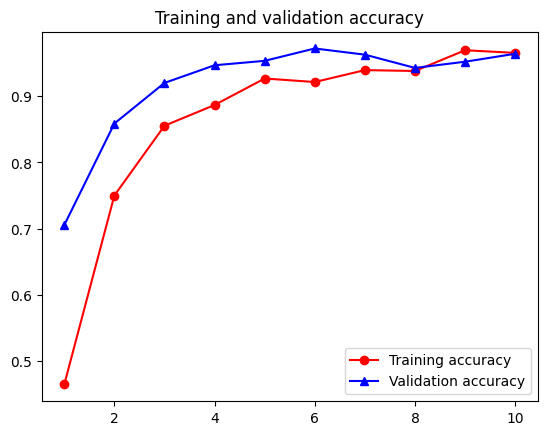

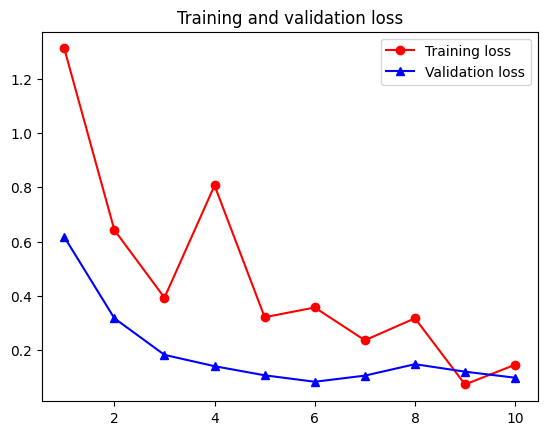

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, label="Training accuracy", marker='o', color='red')
plt.plot(epochs, val_accuracy, label="Validation accuracy", marker='^', color='blue')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss", marker='o', color='red')
plt.plot(epochs, val_loss, label="Validation loss", marker='^', color='blue')
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [21]:
try:
    test_model = keras.models.load_model("part1_convnet.keras")
except OSError:
    test_model = model
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 4s 153ms/step - loss: 0.1189 - accuracy: 0.9573
Test accuracy: 0.957


### Part2 - VGG16

In [36]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape=(image_shape[0], image_shape[1], 3))
x = layers.Rescaling(1./255)(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="part2_vgg16.keras",
        save_best_only=True,
        monitor="val_accuracy")
]

callbacks = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
47/47 [==============================] - 7s 119ms/step - loss: 60600.3203 - accuracy: 0.3727 - val_loss: 67051.5391 - val_accuracy: 0.3333
Epoch 2/30
47/47 [==============================] - 6s 119ms/step - loss: 36494.7383 - accuracy: 0.3773 - val_loss: 21062.8418 - val_accuracy: 0.3360
Epoch 3/30
47/47 [==============================] - 6s 120ms/step - loss: 27096.9336 - accuracy: 0.4000 - val_loss: 29080.9629 - val_accuracy: 0.4827
Epoch 4/30
47/47 [==============================] - 6s 121ms/step - loss: 20895.8125 - accuracy: 0.4540 - val_loss: 8000.3735 - val_accuracy: 0.5600
Epoch 5/30
47/47 [==============================] - 6s 123ms/step - loss: 13236.1416 - accuracy: 0.5440 - val_loss: 26461.9395 - val_accuracy: 0.3587
Epoch 6/30
47/47 [==============================] - 6s 119ms/step - loss: 12904.3857 - accuracy: 0.4993 - val_loss: 11506.3906 - val_accuracy: 0.5920
Epoch 7/30
47/47 [==============================] - 6s 120ms/step - loss: 9605.2256 - accuracy: 0.556

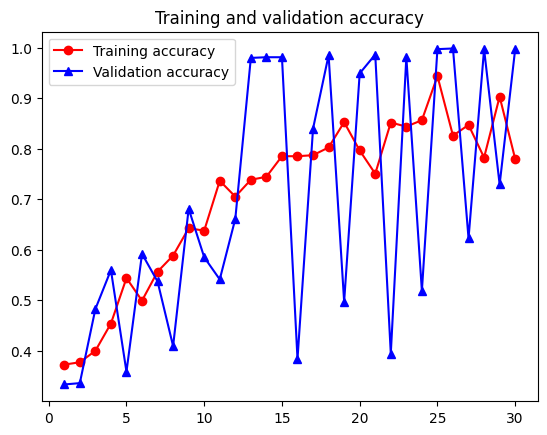

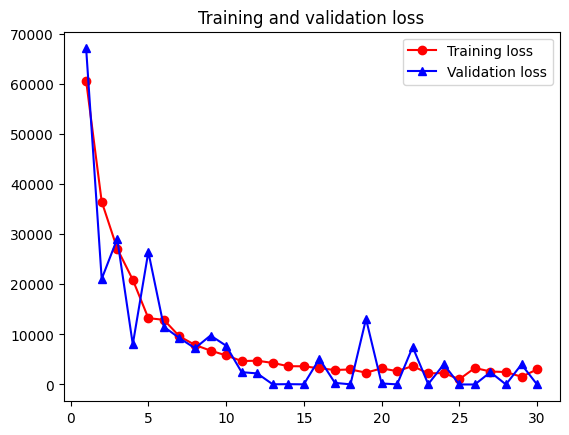

In [37]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, label="Training accuracy", marker='o', color='red')
plt.plot(epochs, val_accuracy, label="Validation accuracy", marker='^', color='blue')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss", marker='o', color='red')
plt.plot(epochs, val_loss, label="Validation loss", marker='^', color='blue')
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [38]:
test_model = model
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

24/24 [==============================] - 1s 22ms/step - loss: 14.5005 - accuracy: 0.9960
Test accuracy: 0.996
